# 1. Import the dependencies and pipeline modules

In [ ]:
# Essential Dependencies Only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pipeline
from data_loader import DataLoader
from data_preprocessor import DataPreprocessor
from feature_selector import FeatureSelector
from model_trainer import ModelTrainer
from pipeline_config import MODEL_CONFIG

# 2. Data loading and display

In [ ]:

from data_loader import DataLoader

loader = DataLoader()
print("🔄 is loading raw data..." )
raw_data = loader.merge_data()

print(f"📊 original data dimension: {raw_data.shape}")
print("\\n📋 preview of original data :")
display(raw_data.head())

INFO:data_loader:Merging all data tables...
INFO:data_loader:Loading diabetic data...


🔄 正在加载原始数据...


INFO:data_loader:Diabetic data loaded: (101766, 50)
INFO:data_loader:Loading ID mapping data...
INFO:data_loader:ID mapping data loaded: (67, 2)
INFO:data_loader:ID mapping data split into three tables
INFO:data_loader:Data merged successfully: (101766, 51)


📊 原始数据维度: (101766, 51)
\n📋 原始数据预览:


,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,25,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,3,?,?,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,2,?,?,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,2,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


## 2.1 Keep the record of the first admission
To accurately predict readmission within the first 30 days, we only retain the first admission record of each patient. This can prevent multiple readmitted records of the same patient from causing bias against the model. All subsequent analyses will be based on this filtered dataset.


In [ ]:
print(f" total number of records before processing: {len(raw_data)}")
print(f" number of independent patients before processing: {raw_data['patient_nbr'].nunique()}")

# Sort by encounter_id to ensure that the first admission record is at the top
df_sorted = raw_data.sort_values(by='encounter_id')

# Delete duplicate patient records and only keep the first one
# Note: We reassign the result to raw_data so that the filtered data can be used in subsequent cells
raw_data = df_sorted.drop_duplicates(subset='patient_nbr', keep='first')

print(f"\n total number of records after processing: {len(raw_data)}")
print(f" number of independent patients after processing: {raw_data['patient_nbr'].nunique()}")

处理前总记录数: 101766
处理前独立患者数: 71518

处理后总记录数: 71518
处理后独立患者数: 71518


## 2.2 Remove patients who are logically ineligible for readmission

According to the description of the dataset, some 'discharge_disposition_id' represent that patients have died or been sent to hospice institutions, and these patients are physiologically impossible to be readmitted. To prevent the model from generating bias, we need to remove these records.

In [ ]:
# Define the ID representing death or end-of-life care
hospice_or_death_ids = [11, 13, 14, 19, 20, 21]

print(f" number of records before processing: {len(raw_data)}")

# Filter out the records that do not contain these ids
raw_data = raw_data[~raw_data['discharge_disposition_id'].isin(hospice_or_death_ids)]

print(f" The number of remaining records after removing patients who cannot be readmitted: {len(raw_data)}")

处理前记录数: 71518
移除不可能再入院的患者后，剩余记录数: 69973


# 3. Data Preprocessing and EDA

In [ ]:
preprocessor = DataPreprocessor()
df = preprocessor.apply_feature_engineering(raw_data)
df = preprocessor.prepare_target_variable(df)
# The number of comorbidity is 2 to 3
df =df[df['comorbidity'] == 1]
print(f" Data volume after sensitivity analysis: {df.shape}")
print(f" Data dimension after feature engineering: {df.shape}")
display(df.head())

INFO:data_preprocessor:Applying feature engineering...
INFO:data_preprocessor:Original number of encounters: 69973
INFO:data_preprocessor:Encounters after keeping first admission: 69973
INFO:data_preprocessor:Removed 0 records for hospice/death dispositions.
INFO:data_preprocessor:Encounters after removing hospice/death: 69973
INFO:data_preprocessor:Handling missing values based on notebook's standard...
INFO:data_preprocessor:Replaced '?' with NaN.
INFO:data_preprocessor:🔴 Dropped columns with >50.0% missing: ['weight', 'max_glu_serum', 'A1Cresult']
INFO:data_preprocessor:🟡 Filling specified columns with 'Unknown': ['medical_specialty', 'payer_code', 'race', 'diag_1', 'diag_2', 'diag_3', 'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']
INFO:data_preprocessor:✅ All missing values have been handled successfully.
INFO:data_preprocessor:Creating age-related features...
INFO:data_preprocessor:Creating diagnosis-related features...
INFO:data_preprocessor:Creatin

敏感性分析后数据量: (3238, 56)
特征工程后数据维度: (3238, 56)


,encounter_id,patient_nbr,race,gender,age,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,discharge_disposition_desc,admission_source_desc,age_midpoint,age_group,diag_1_category,diag_2_category,diag_3_category,comorbidity,encounter_index,readmitted_binary
17,84222,108662661,Caucasian,Female,[50-60),1,3,Unknown,Cardiology,29,...,Discharged to home,Emergency Room,80,50-60,other,neoplasms,diabetes,1,1,0
25,221634,21861756,Other,Female,[50-60),1,1,Unknown,Unknown,33,...,Discharged to home,Emergency Room,80,50-60,other,circulatory,diabetes,1,1,0
27,248916,115196778,Caucasian,Female,[50-60),1,2,Unknown,Surgery-General,25,...,Discharged to home,Physician Referral,80,50-60,injuries,genitourinary,diabetes,1,1,0
37,326028,112002975,Caucasian,Female,[60-70),1,4,Unknown,Unknown,33,...,Discharged to home,Emergency Room,95,60-70,respiratory,other,diabetes,1,1,0
47,498030,51838164,Caucasian,Male,[70-80),3,9,Unknown,Unknown,2,...,Discharged/transferred to SNF,Transfer from a hospital,110,70-80,other,genitourinary,diabetes,1,1,0


count    3238.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: comorbidity, dtype: float64
comorbidity
1    3238
Name: count, dtype: int64


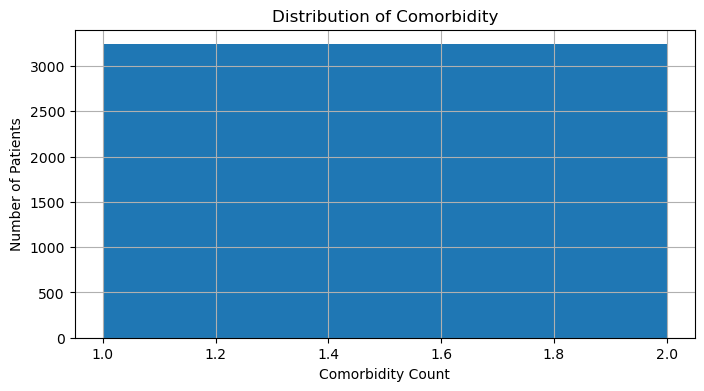

In [ ]:
# View the distribution of comorbidities
print(df['comorbidity'].describe())
print(df['comorbidity'].value_counts().sort_index())
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df['comorbidity'].hist(bins=range(int(df['comorbidity'].min()), int(df['comorbidity'].max())+2))
plt.xlabel('Comorbidity Count')
plt.ylabel('Number of Patients')
plt.title('Distribution of Comorbidity')
plt.show()

## 3.1 Missuing data handling

In [ ]:
# 3.1 Statistics of Basic Missing Values
print("=== Basic Missing Value Statistics ===")
missing_counts = raw_data.isnull().sum()
missing_percentage = (missing_counts / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f" a total of {len(missing_df)} columns have missing values ")
display(missing_df)

=== 基础缺失值统计 ===
总共有 5 个列存在缺失值


,Column,Missing_Count,Missing_Percentage
20,max_glu_serum,66625,95.215297
21,A1Cresult,57128,81.642919
50,admission_source_desc,4820,6.888371
48,admission_type_desc,4516,6.453918
49,discharge_disposition_desc,2474,3.535649


In [ ]:
# 3.2 Check Special Characters '? The missing value represented by '
print("=== Special characters ? Statistics ===")
question_mark_counts = (raw_data == '?').sum()
question_mark_percentage = (question_mark_counts / len(raw_data)) * 100

question_mark_df = pd.DataFrame({
    'Column': question_mark_counts.index,
    'Question_Mark_Count': question_mark_counts.values,
    'Question_Mark_Percentage': question_mark_percentage.values
})
question_mark_df = question_mark_df[question_mark_df['Question_Mark_Count'] > 0].sort_values('Question_Mark_Percentage', ascending=False)

print(f"totally have {len(question_mark_df)} Each column contains missing Character")
display(question_mark_df)

=== 特殊字符 '?' 统计 ===
总共有 7 个列包含 '?' 字符


,Column,Question_Mark_Count,Question_Mark_Percentage
5,weight,67185,96.015606
9,medical_specialty,33639,48.074257
8,payer_code,30415,43.466766
2,race,1918,2.741057
18,diag_3,1224,1.749246
17,diag_2,293,0.418733
16,diag_1,10,0.014291


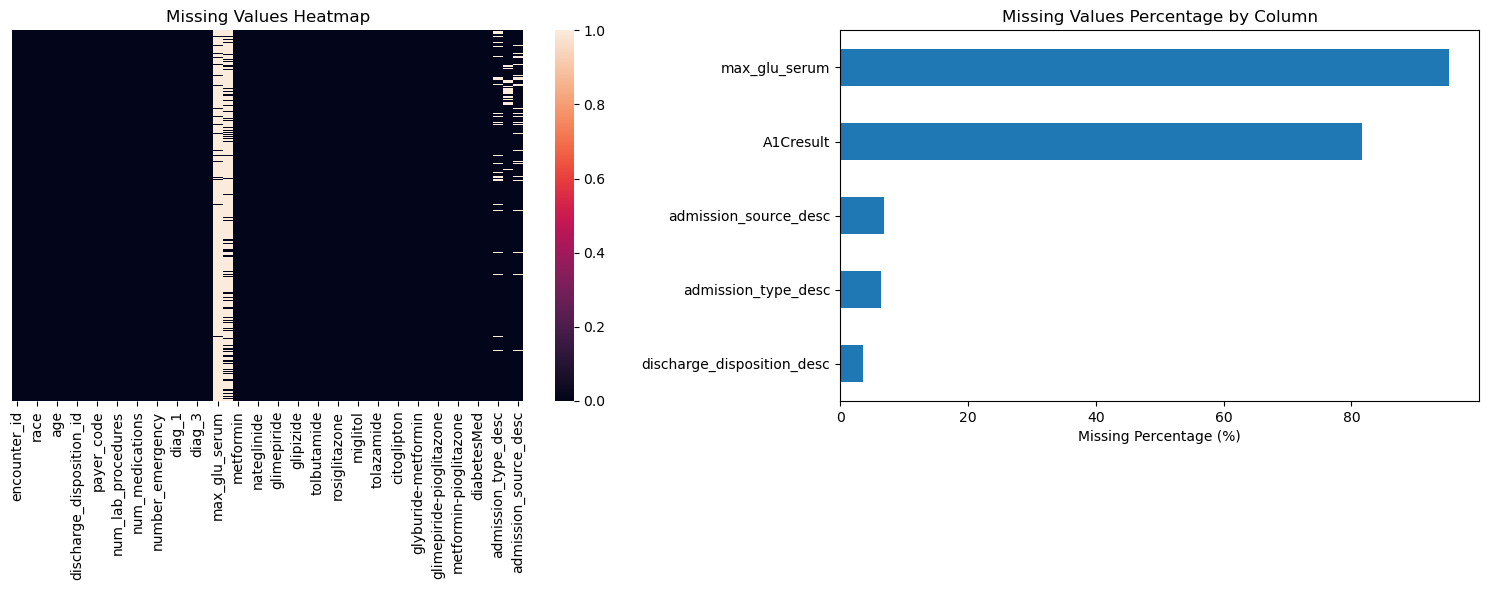

In [ ]:
# 3.3 Visualization of Missing Values
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Missing Value Heat Map
missing_data = raw_data.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Percentage of Missing Values Bar chart
missing_percentage_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=True)
missing_percentage_sorted.plot(kind='barh', ax=axes[1])
axes[1].set_title('Missing Values Percentage by Column')
axes[1].set_xlabel('Missing Percentage (%)')

plt.tight_layout()
plt.show()

In [ ]:
# 3.4 Missing Value Handling Decision (Completely Consistent with Pipeline Logic)
print("=== Missing Value Handling Decision (consistent with Pipeline logic) ===")
print(" Based on the processing standard in data_preprocessor.py, we generate the following decision table: ")
print()

# -- To conduct an accurate analysis, first simulate the first step of the pipeline: to '? Replace 'with NaN --
analysis_df = raw_data.replace('? ', np.nan)
missing_percentage = (analysis_df.isnull().sum() / len(analysis_df)) * 100

# Define thresholds and fill columns exactly the same as the pipeline
drop_missing_threshold = 50.0
cols_to_fill_with_unknown = [
    'medical_specialty', 'payer_code', 'race',
    'diag_1', 'diag_2', 'diag_3',
    'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc'
]

# --- 生成与pipeline行为一致的决策表 ---
decision_data = []
all_missing_cols_df = missing_percentage[missing_percentage > 0]

for col, percentage in all_missing_cols_df.items():
    
    if percentage > drop_missing_threshold:
        action = "Delete"
        reason = f" missing rate ({percentage:.1f}%) > {drop_missing_threshold}%"
    elif col in cols_to_fill_with_unknown:
        action = "Reserve, fill with 'Unknown'"
        reason = f" Predefined padding Columns"
    else:
        action = "Reserved, no processing specified"
        reason = "Low missing rate but not in the fill list"

decision_data.append([col, f"{percentage:.1f}%", action, reason])

decision_df = pd.DataFrame(decision_data, columns=['column name', 'miss rate', 'Processing method', ' Reason'])
decision_df = decision_df.sort_values('miss rate', ascending=False)

print("📋 Missing Value handling decision Table (synchronized with Pipeline):")
display(decision_df)

=== 缺失值处理决策（与Pipeline逻辑一致） ===
基于data_preprocessor.py中的处理标准，我们生成以下决策表：

📋 缺失值处理决策表 (与Pipeline同步):


,列名,缺失率,处理方式,原因
1,weight,96.0%,删除,缺失率 (96.0%) > 50.0%
7,max_glu_serum,95.2%,删除,缺失率 (95.2%) > 50.0%
8,A1Cresult,81.6%,删除,缺失率 (81.6%) > 50.0%
11,admission_source_desc,6.9%,"保留, 用'Unknown'填充",预定义的填充列
9,admission_type_desc,6.5%,"保留, 用'Unknown'填充",预定义的填充列
3,medical_specialty,48.1%,"保留, 用'Unknown'填充",预定义的填充列
2,payer_code,43.5%,"保留, 用'Unknown'填充",预定义的填充列
10,discharge_disposition_desc,3.5%,"保留, 用'Unknown'填充",预定义的填充列
0,race,2.7%,"保留, 用'Unknown'填充",预定义的填充列
6,diag_3,1.7%,"保留, 用'Unknown'填充",预定义的填充列


## 3.2 EDA

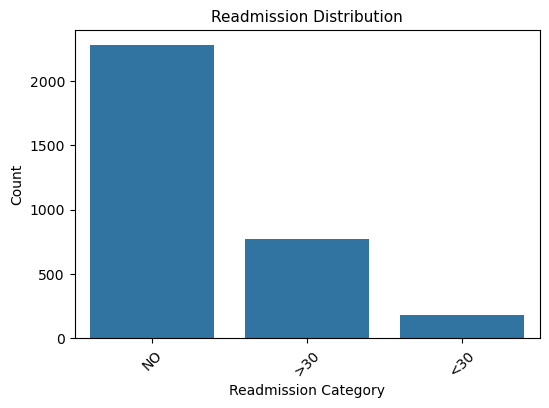

readmitted
NO     2285
>30     772
<30     181
Name: count, dtype: int64
No missing values found.
The average age of patients is: 76.27 years
Average stay at hospital by Age Group In Days
age_group
0-10      2.453333
10-20     2.423077
20-30     2.375000
30-40     2.573134
40-50     2.686567
50-60     2.687500
60-70     2.715808
70-80     2.930085
80-90     3.358696
90-100    4.480000
Name: time_in_hospital, dtype: float64


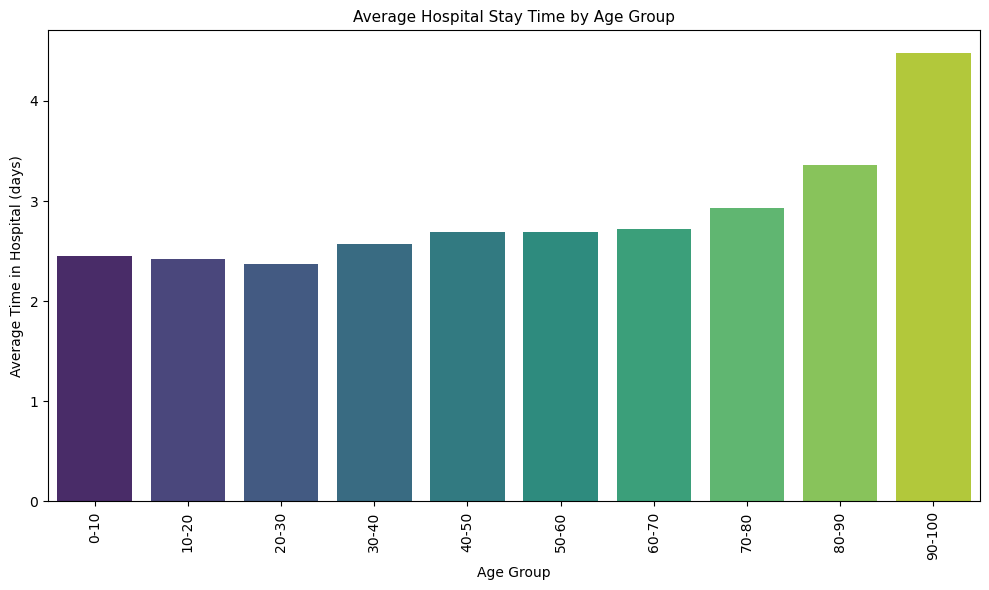

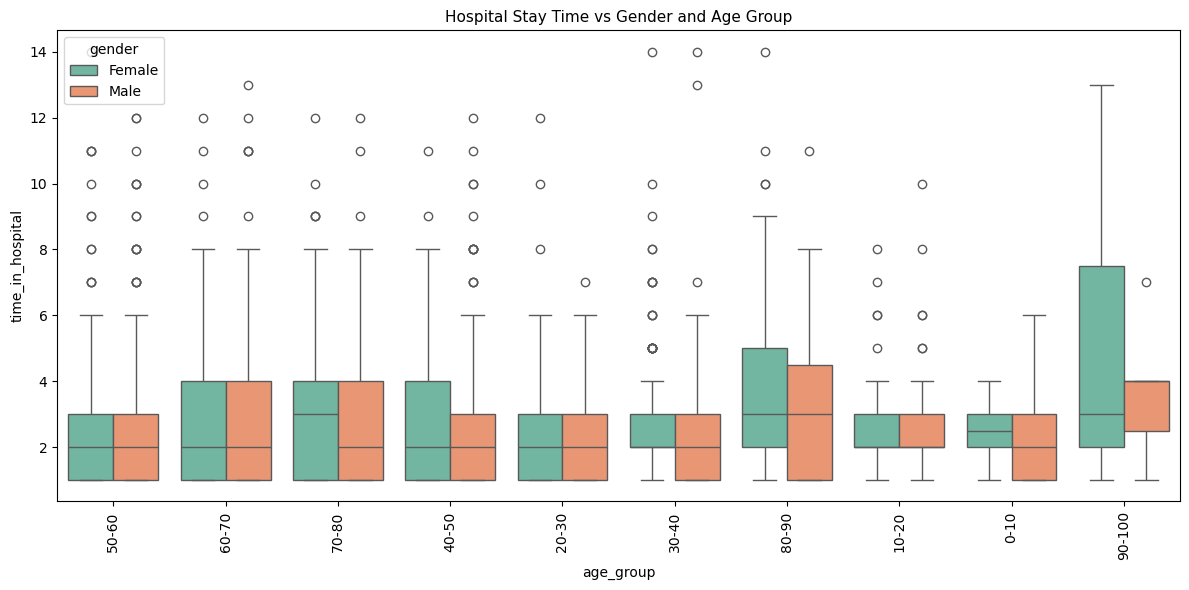

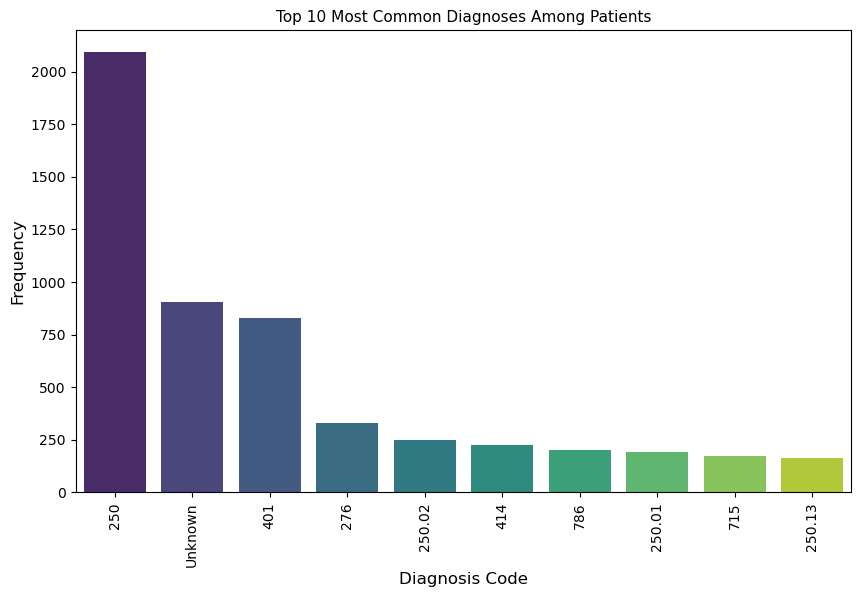

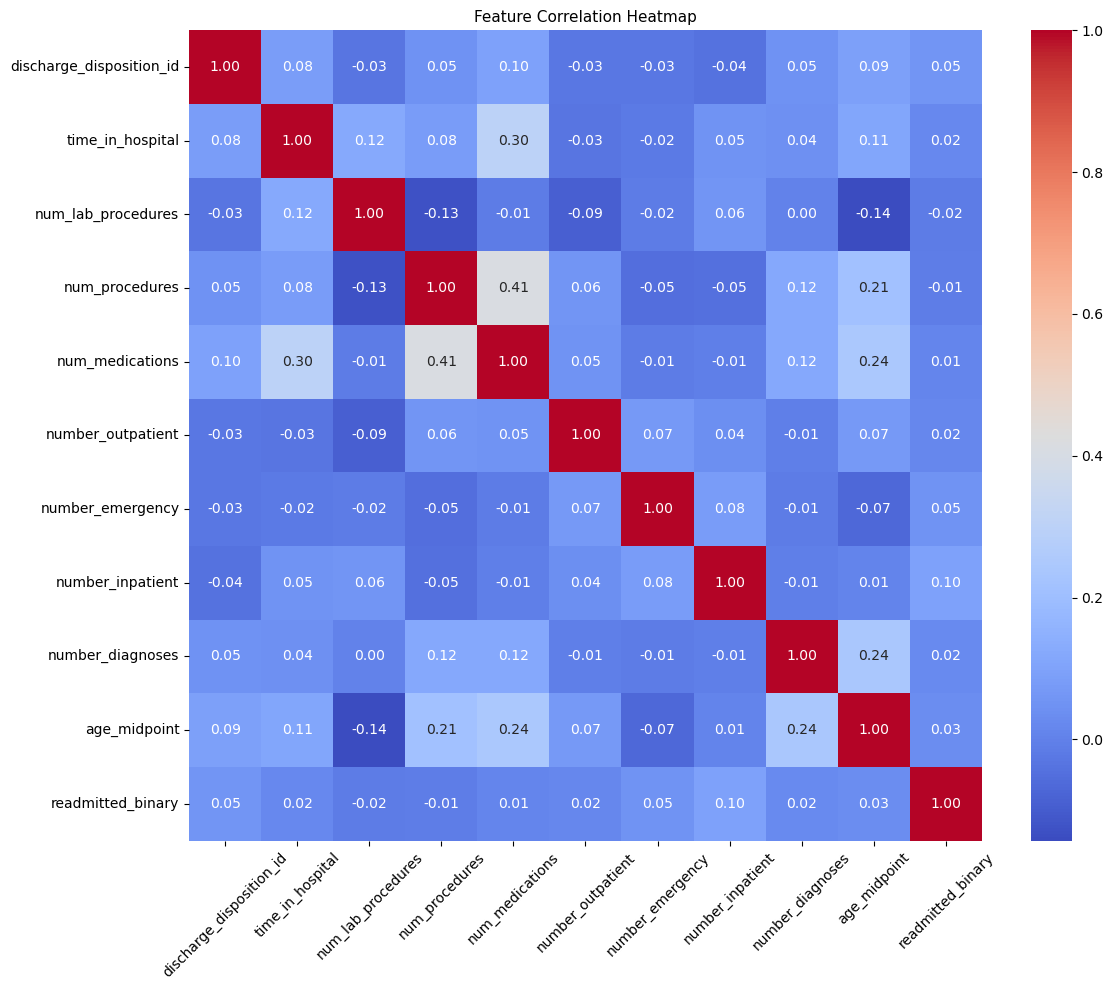

In [ ]:
from eda_analyzer import EDAAnalyzer

# Select the data table you want to analyze
eda = EDAAnalyzer(df) # or processed_data

# 1. readmission distribution
eda.plot_readmission_distribution()

# 2. Distribution of Missing Values
eda.plot_missing_values()

# 1. Average age
eda.plot_average_age()

# 2. Draw a bar chart of the average length of hospital stay by age group
eda.plot_avg_stay_by_age_group()

# 3. Draw box plots of the length of hospital stay by age group and gender
eda.plot_avg_stay_by_age_gender_box()

# 4. Distribution of the top 10 diagnoses
eda.plot_top_diagnoses_simple()

# 5. Feature Correlation Heat Map

eda = EDAAnalyzer(df)  # 或 processed_data


# 4. Medical interpretation

## 4.1 Readdmision rate with Age group & gender 

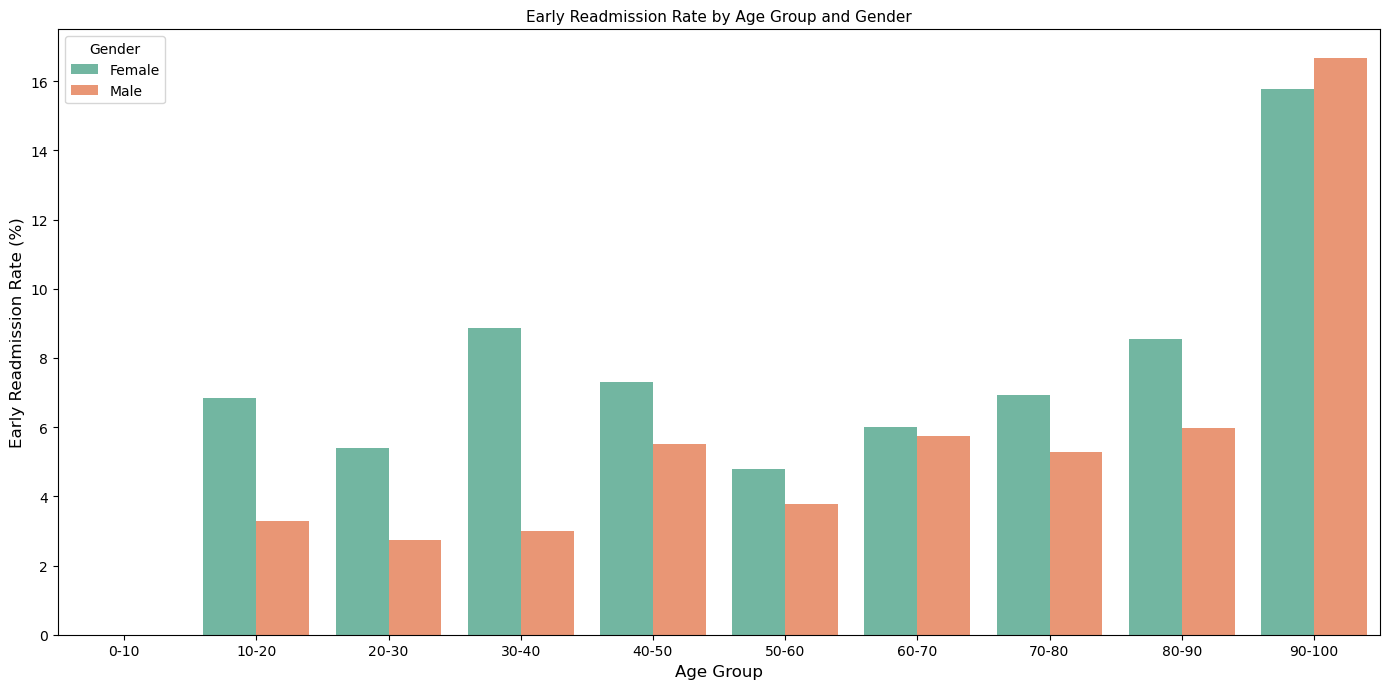

Readmission Rate Heatmap Table (age_group x gender_readmit):
gender_readmit  Early Readmission-Female  Early Readmission-Male  \
age_group                                                          
0-10                            0.000000                0.000000   
10-20                           3.846154                1.442308   
20-30                           3.260870                1.086957   
30-40                           4.477612                1.492537   
40-50                           3.358209                2.985075   
50-60                           2.286585                1.981707   
60-70                           2.841918                3.019538   
70-80                           3.601695                2.542373   
80-90                           5.434783                2.173913   
90-100                         12.000000                4.000000   

gender_readmit  No Early Readmission-Female  No Early Readmission-Male  
age_group                                        

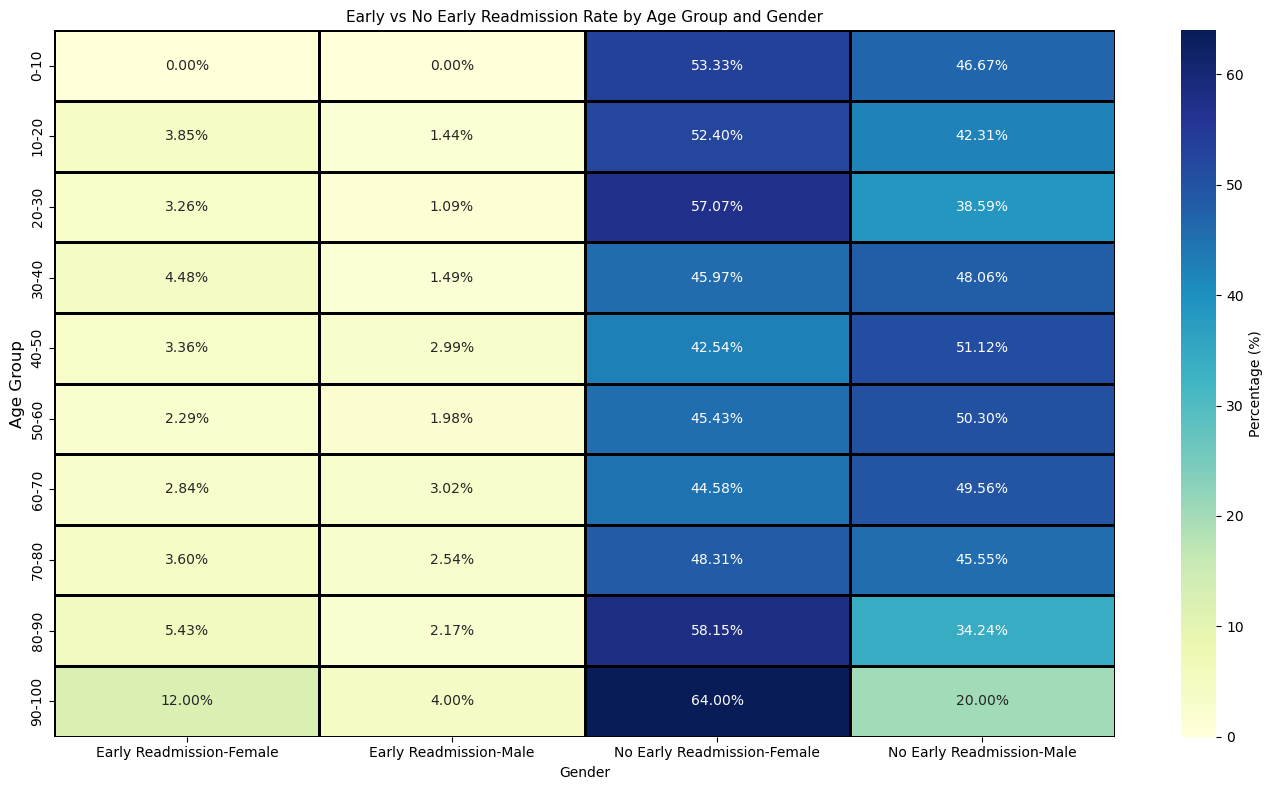

gender_readmit,Early Readmission-Female,Early Readmission-Male,No Early Readmission-Female,No Early Readmission-Male
age_group,,,,
0-10,0.000000,0.000000,53.333333,46.666667
10-20,3.846154,1.442308,52.403846,42.307692
20-30,3.260870,1.086957,57.065217,38.586957
30-40,4.477612,1.492537,45.970149,48.059701
40-50,3.358209,2.985075,42.537313,51.119403
50-60,2.286585,1.981707,45.426829,50.304878
60-70,2.841918,3.019538,44.582593,49.555950
70-80,3.601695,2.542373,48.305085,45.550847
80-90,5.434783,2.173913,58.152174,34.239130


In [ ]:
#Statistically analyze and visualize the distribution of readmission rates among different age groups and genders
eda.plot_readmission_rate_by_age_gender()

# Draw the heat maps of <30/>30 readmission rate under age_group and gender
eda.plot_readmission_rate_heatmap_by_age_gender()



## 4.2  Relationship between comorbidities (e.g., diabetes, heart disease) and Readmission Rates

Readmission rate by comorbidity (%):
readmit_bin      Early Readmission Rate (%)  No Early Readmission Rate (%)
comorbidity                                                               
circulatory                        6.749418                      93.250582
diabetes                           4.776739                      95.223261
digestive                          2.631579                      97.368421
genitourinary                      8.333333                      91.666667
injuries                           0.000000                     100.000000
musculoskeletal                    0.000000                     100.000000
neoplasms                         14.285714                      85.714286
other                              5.045872                      94.954128
respiratory                        3.846154                      96.153846


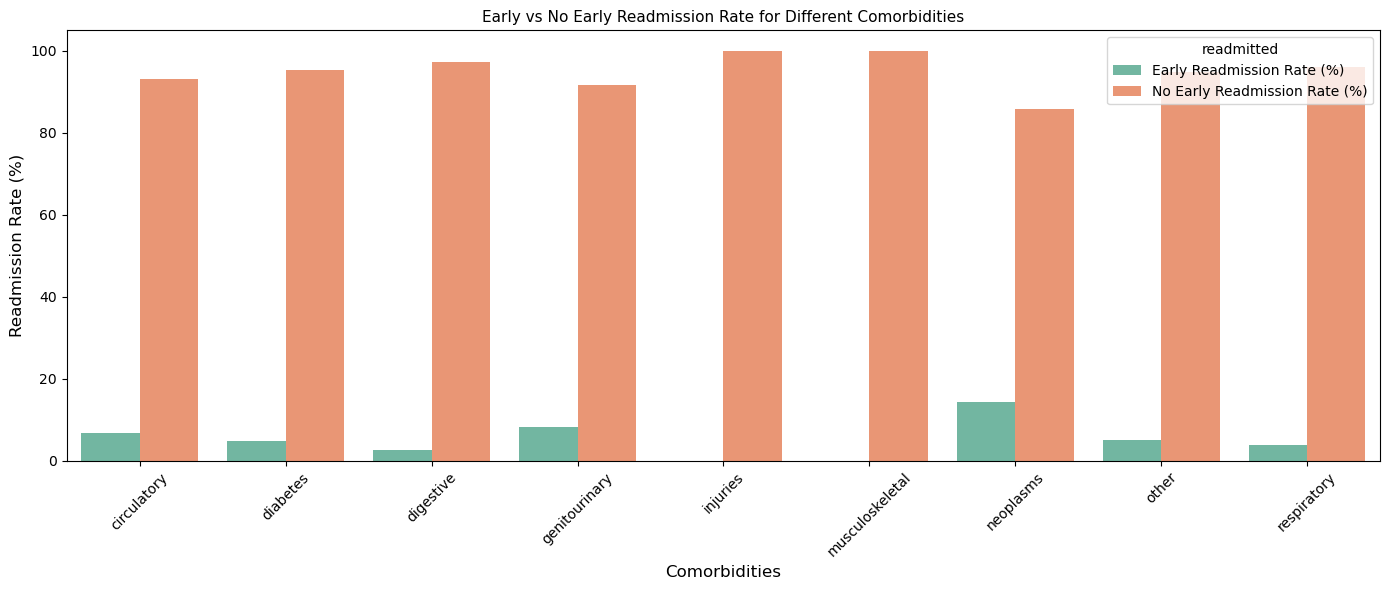

readmit_bin,comorbidity,Early Readmission Rate (%),No Early Readmission Rate (%)
0,circulatory,6.749418,93.250582
1,diabetes,4.776739,95.223261
2,digestive,2.631579,97.368421
3,genitourinary,8.333333,91.666667
4,injuries,0.000000,100.000000
5,musculoskeletal,0.000000,100.000000
6,neoplasms,14.285714,85.714286
7,other,5.045872,94.954128
8,respiratory,3.846154,96.153846


In [13]:
eda.plot_comorbidity_vs_readmission(preprocessor.icd9_to_nine_category)

## 4.3 Medication

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   No Change  20.000000
1                   glimepiride   Not Given  18.965517
2                     glipizide   Decreased  66.666667
3                     glipizide   Increased  20.000000
4                     glipizide   No Change  19.791667
5                     glipizide   Not Given  18.727915
6           glipizide-metformin   Not Given  18.992655
7                     glyburide   Decreased  20.000000
8                     glyburide   Increased  50.000000
9                     glyburide   No Change  23.958333
10                    glyburide   Not Given  18.278302
11          glyburide-metformin   No Change   9.090909
12          glyburide-metformin   Not Given  19.108280
13                      insulin   Decreased  16.666667
14                      insulin   Increased  13.978495
15                      insulin   No Change  17.938931
16      

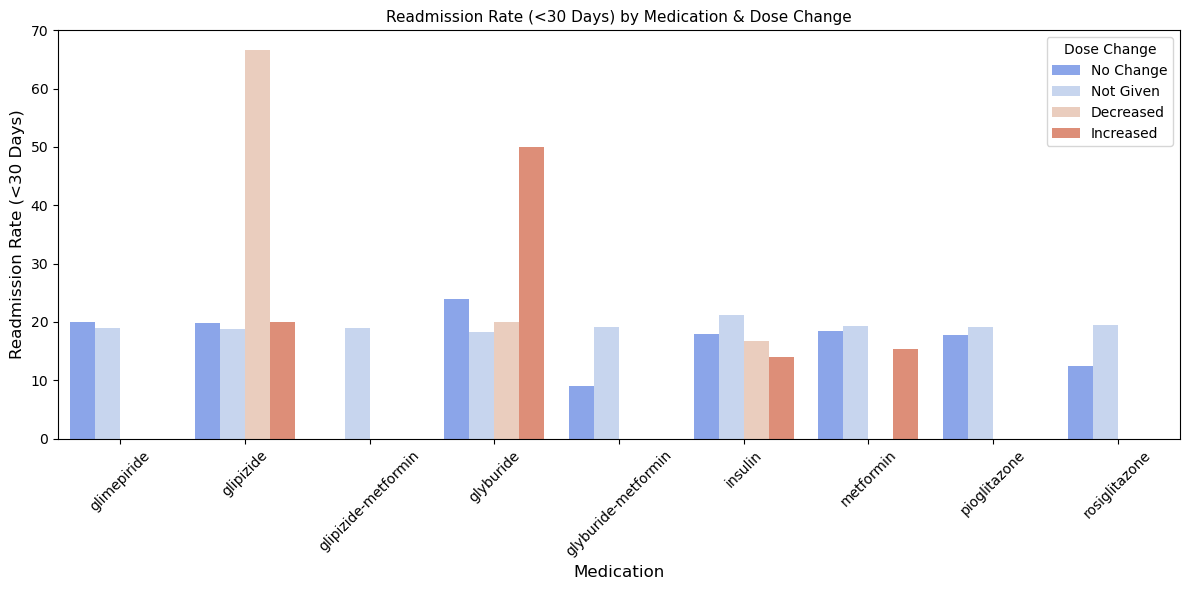

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   No Change  20.000000
1                   glimepiride   Not Given  18.965517
2                     glipizide   Decreased  66.666667
3                     glipizide   Increased  20.000000
4                     glipizide   No Change  19.791667
5                     glipizide   Not Given  18.727915
6           glipizide-metformin   Not Given  18.992655
7                     glyburide   Decreased  20.000000
8                     glyburide   Increased  50.000000
9                     glyburide   No Change  23.958333
10                    glyburide   Not Given  18.278302
11          glyburide-metformin   No Change   9.090909
12          glyburide-metformin   Not Given  19.108280
13                      insulin   Decreased  16.666667
14                      insulin   Increased  13.978495
15                      insulin   No Change  17.938931
16      

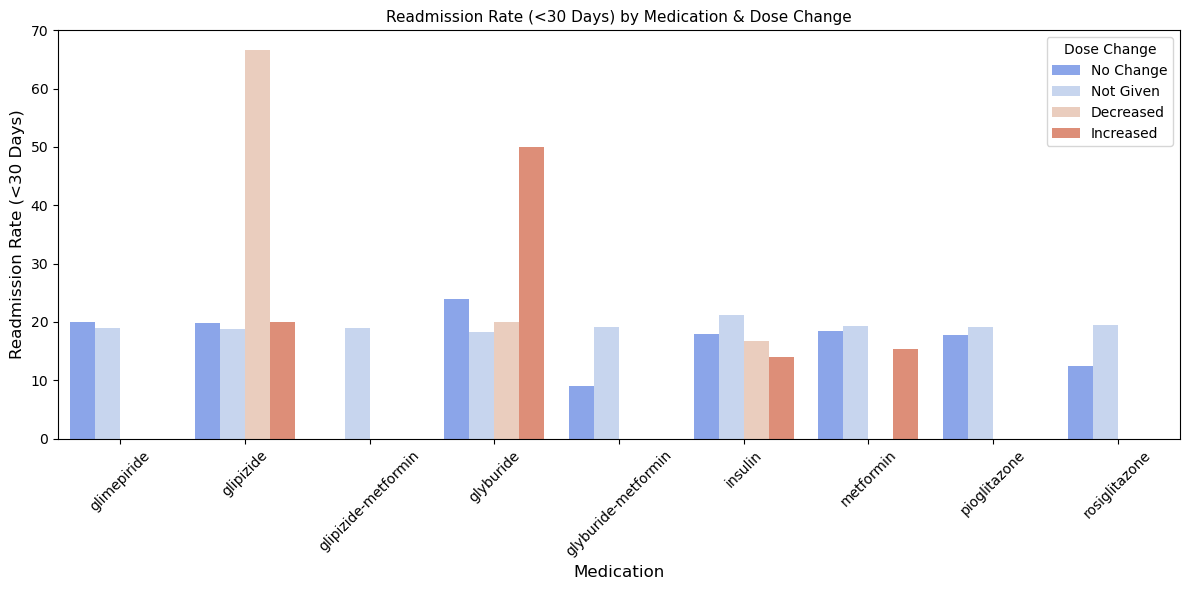

Readmission Rate (<30 Days) Heatmap Table:
Dose Change          Decreased  Increased  No Change  Not Given
Medication                                                     
glimepiride                NaN        NaN  20.000000  18.965517
glipizide            66.666667  20.000000  19.791667  18.727915
glipizide-metformin        NaN        NaN        NaN  18.992655
glyburide            20.000000  50.000000  23.958333  18.278302
glyburide-metformin        NaN        NaN   9.090909  19.108280
insulin              16.666667  13.978495  17.938931  21.186441
metformin                  NaN  15.384615  18.518519  19.252078
pioglitazone               NaN        NaN  17.741935  19.101124
rosiglitazone              NaN        NaN  12.500000  19.441341


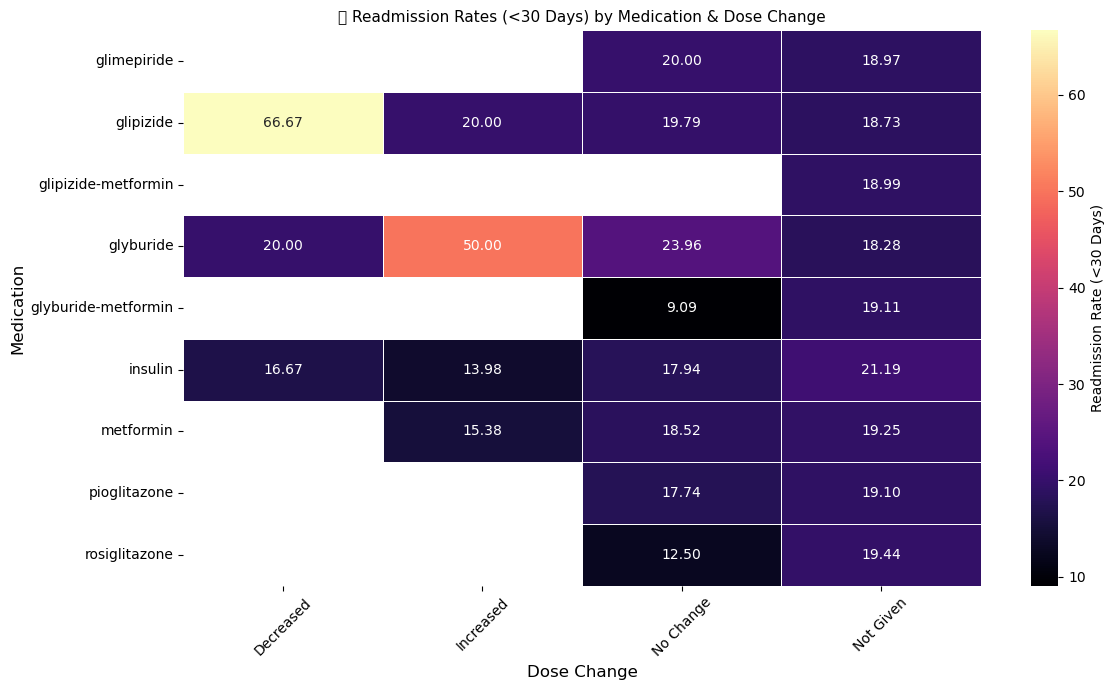

Dose Change,Decreased,Increased,No Change,Not Given
Medication,,,,
glimepiride,NaN,NaN,20.000000,18.965517
glipizide,66.666667,20.000000,19.791667,18.727915
glipizide-metformin,NaN,NaN,NaN,18.992655
glyburide,20.000000,50.000000,23.958333,18.278302
glyburide-metformin,NaN,NaN,9.090909,19.108280
insulin,16.666667,13.978495,17.938931,21.186441
metformin,NaN,15.384615,18.518519,19.252078
pioglitazone,NaN,NaN,17.741935,19.101124
rosiglitazone,NaN,NaN,12.500000,19.441341


In [14]:


eda.plot_readmission_by_medication_and_dose()
# 热力图
eda.plot_readmission_by_medication_and_dose_heatmap()

# 5.Feature Engineering

## 5.1 Dataset division and encoding

In [ ]:
# Before modeling, drop the grouping variables and their source variables
drop_cols = ['comorbidity', 'number_diagnoses']

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(df)
X_train, X_val, X_test = preprocessor.encode_categorical_features(X_train, X_val, X_test)
X_train, X_val, X_test = preprocessor.scale_numerical_features(X_train, X_val, X_test)
X_train_balanced, y_train_balanced = preprocessor.apply_smote(X_train, y_train)
print(f'The number of samples in the training set after balancing: {X_train_balanced.shape[0]}')

INFO:data_preprocessor:Splitting data into train/validation/test sets...
INFO:data_preprocessor:Dropping unused ID and target columns before splitting: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'readmitted']
INFO:data_preprocessor:Data split - Train: (2072, 51), Val: (518, 51), Test: (648, 51)
INFO:data_preprocessor:Encoding categorical features using label encoding...
INFO:data_preprocessor:Scaling numerical features...
INFO:data_preprocessor:Applying SMOTE for class balancing...
INFO:data_preprocessor:Before SMOTE - Class distribution: {0: 1956, 1: 116}
INFO:data_preprocessor:After SMOTE - Class distribution: {0: 1956, 1: 1956}


The number of samples in the training set after balancing: 3912


## 5.2 Top_N Feature selection

In [ ]:
# ===============================================================
#          Multi-top N value feature selection and result presentation
# ===============================================================

# 1. Set the list of top_n values that you want to test
top_n_list = [ 5,10,15]  # You can modify this list at will
print(f"The Top N value to be tested: {top_n_list}")

# 2. Create a feature selector
selector = FeatureSelector()

# 3. Run feature selection with multiple top_n values
print("\nStart running feature selection with multiple Top N values...")
multiple_results = selector.select_features_multiple_topn(
    X_train_balanced, 
    y_train_balanced, 
    top_n_list
)
print("Feature selection is completed.！")


from feature_selector import flatten_multiple_results
selected_features_dict = flatten_multiple_results(multiple_results)

# 5. (可选) 选择一组特征进行后续步骤
#    您可以根据上面的表格结果，选择一组最满意的特征
#    例如，选择top_n=10时，L1方法选择的特征
# ---------------------------------------------------------------
# chosen_top_n = 10
# chosen_method = 'L1'
# X_selected = X_train_balanced[multiple_results[chosen_top_n][chosen_method]]
# print(f"\n proceeding with top_n={chosen_top_n} and method='{chosen_method}'")
# print(f"Selected {len(X_selected.columns)} features.")

INFO:feature_selector:Running feature selection with multiple top_n values: [5, 10, 15]
INFO:feature_selector:Processing top_n = 5
INFO:feature_selector:Running all feature selection methods with top_n=5...
INFO:feature_selector:Selecting top 5 features using L1 regularization...
INFO:feature_selector:L1 feature selection completed. Selected features: ['diabetesMed', 'number_diagnoses', 'diag_3', 'insulin', 'repaglinide']
INFO:feature_selector:Selecting top 5 features using Mutual Information...


将要测试的Top N值: [5, 10, 15]

🚀 开始运行多个Top N值的特征选择...


INFO:feature_selector:Mutual Information feature selection completed. Selected features: ['num_lab_procedures', 'num_medications', 'age_group', 'age_midpoint', 'age']
INFO:feature_selector:Selecting top 5 features using Tree-based importance...
INFO:feature_selector:Tree-based feature selection completed. Selected features: ['admission_source_desc', 'time_in_hospital', 'payer_code', 'insulin', 'gender']
INFO:feature_selector:All feature selection methods completed
INFO:feature_selector:Processing top_n = 10
INFO:feature_selector:Running all feature selection methods with top_n=10...
INFO:feature_selector:Selecting top 10 features using L1 regularization...
INFO:feature_selector:L1 feature selection completed. Selected features: ['diabetesMed', 'number_diagnoses', 'diag_3', 'insulin', 'repaglinide', 'nateglinide', 'rosiglitazone', 'chlorpropamide', 'gender', 'num_medications']
INFO:feature_selector:Selecting top 10 features using Mutual Information...
INFO:feature_selector:Mutual Inform

✅ 特征选择完成！


## 5.3 Feature selection visualization


📊 Multiple Top N Value Feature Selection Detailed Results:


,Top N,Method,Selected Features
0,5,L1,"[diabetesMed, number_diagnoses, diag_3, insulin, repaglinide]"
1,5,MutualInfo,"[num_lab_procedures, num_medications, age_group, age_midpoint, age]"
2,5,TreeImportance,"[admission_source_desc, time_in_hospital, payer_code, insulin, gender]"
3,10,L1,"[diabetesMed, number_diagnoses, diag_3, insulin, repaglinide, nateglinide, rosiglitazone, chlorp..."
4,10,MutualInfo,"[num_lab_procedures, num_medications, age_group, age_midpoint, age, medical_specialty, time_in_h..."
5,10,TreeImportance,"[admission_source_desc, time_in_hospital, payer_code, insulin, gender, diag_3, discharge_disposi..."
6,15,L1,"[diabetesMed, number_diagnoses, diag_3, insulin, repaglinide, nateglinide, rosiglitazone, chlorp..."
7,15,MutualInfo,"[num_lab_procedures, num_medications, age_group, age_midpoint, age, medical_specialty, time_in_h..."
8,15,TreeImportance,"[admission_source_desc, time_in_hospital, payer_code, insulin, gender, diag_3, discharge_disposi..."


INFO:feature_selector:Found 1 features selected by at least 2 methods
INFO:feature_selector:Found 0 features selected by at least 3 methods
INFO:feature_selector:Found 6 features selected by at least 2 methods
INFO:feature_selector:Found 1 features selected by at least 3 methods
INFO:feature_selector:Found 15 features selected by at least 2 methods
INFO:feature_selector:Found 2 features selected by at least 3 methods



🔍 Common Features Summary by Top N Value:


,Top N,Common Features (>=2 methods),Common Features (all 3 methods)
0,5,[insulin],[]
1,10,"[diag_3, insulin, gender, num_medications, age_midpoint, time_in_hospital]",[num_medications]
2,15,"[diag_3, insulin, gender, num_medications, discharge_disposition_desc, num_lab_procedures, age_g...","[insulin, num_medications]"



🎨 Generating Feature Selection Matrix Visualization Chart:


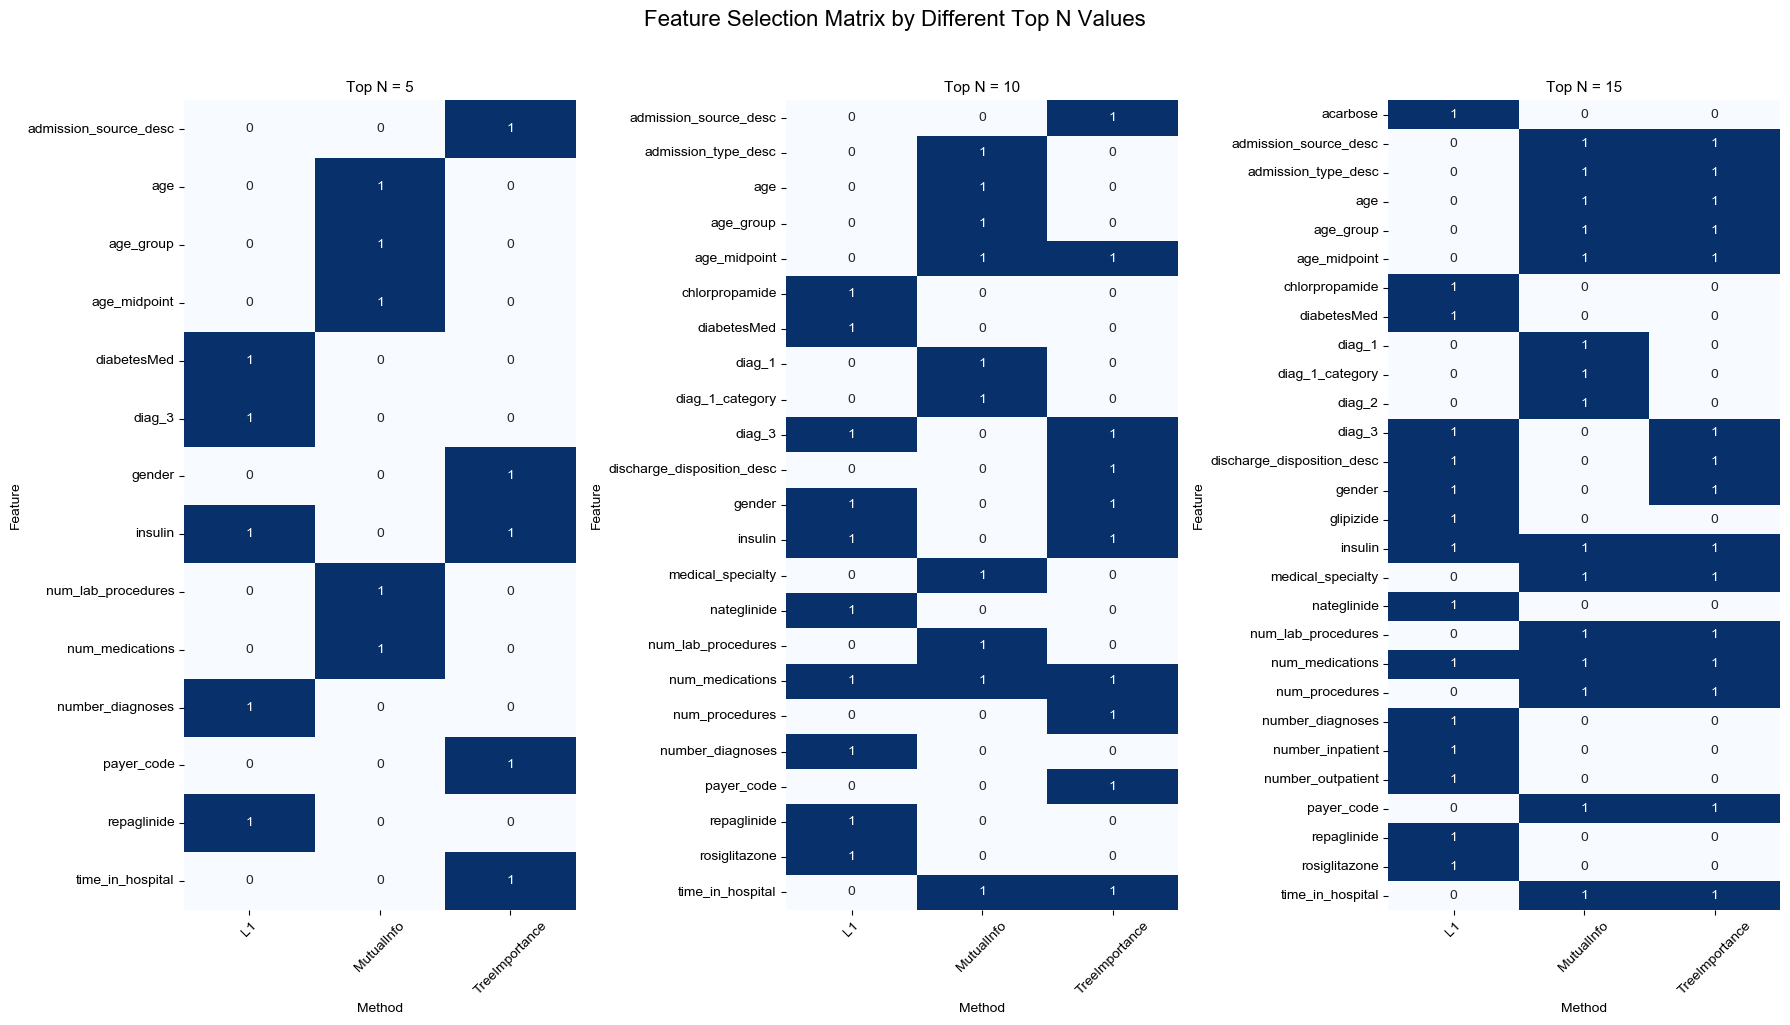

In [ ]:

# 4. Display the results in table form
selector.display_multiple_topn_results(multiple_results)

# 5. [New Addition] Visual feature selection matrix
selector.plot_feature_selection_matrix(multiple_results)


# 6. Model training and evaluation

In [21]:
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'discharge_disposition_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_disposition_desc',
       'admission_source_desc', 'age_midpoint', 'age_group', 'diag_1_category',
       'diag_2_category', 'diag_3_category'

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import os

# Set parameters (these are kept in the notebook for easy modification)
fs_names = ['L1', 'MutualInfo', 'TreeImportance']
top_n = 15
cv_folds = 5  # It can be changed to 5.

# Define the model and parameter mesh
model_classes = {
    'RandomForest': RandomForestClassifier,
    'LogisticRegression': LogisticRegression,
    'XGBoost': XGBClassifier
}

## final Version 

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 500],
        'max_depth': [None,  10, 20],
        'min_samples_split': [2,  10],
        'min_samples_leaf': [1,  4]

    },
    'LogisticRegression': {
        'C': [ 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000]
    },
    'XGBoost': {
        'n_estimators': [100, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3,  7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8,  1.0]
    }
}



# 第二次调参

# param_grids = {
#     'RandomForest': {
#     'n_estimators': [400, 500, 600],
#     'max_depth': [None, 20, 30, 40],
#     'min_samples_split': [2, 3, 5],
#     'min_samples_leaf': [1, 2, 3]
#     },
#     'LogisticRegression': {
#     'C': [0.05, 0.1, 0.2, 0.5, 1],
#     'solver': ['liblinear', 'saga'],
#     'penalty': ['l1'],
#     'max_iter': [1000]
#     },
#     'XGBoost': {
#     'n_estimators': [100, 300],
#     'learning_rate': [0.05, 0.07, 0.13],
#     'max_depth': [6,  8],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     # 'reg_alpha': [0, 0.1],
#     # 'reg_lambda': [0]
#     }
# }

# # 第三次调参 取消，因为发现第二次的不如第一次的好
# param_grids = {
#     'RandomForest': {
#     'n_estimators': [500, 550, 600, 650],
#     'max_depth': [25, 30, 35, None],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
#     },
#     'LogisticRegression': {
#     'C': [0.01, 0.03, 0.05, 0.07, 0.1],
#     'solver': ['liblinear'],
#     'penalty': ['l1'],
#     'max_iter': [1000]
#     },
#     'XGBoost': {
#     'n_estimators': [200, 250,300],
#     'learning_rate': [ 0.04, 0.05, 0.06, 0.07],
#     'max_depth': [7,10],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree': [ 0.8, 0.85, 0.9],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [0,0.1]
#     }
# }


In [ ]:

# Call the methods in the py file

model_trainer = ModelTrainer()
all_val_results, all_test_results, all_cv_results_list = model_trainer.run_grid_search_for_all_fs_methods(
    fs_names=fs_names,
    top_n=top_n,
    selected_features_dict=selected_features_dict,
    model_classes=model_classes,
    param_grids=param_grids,
    X_train_balanced=X_train_balanced,
    y_train_balanced=y_train_balanced,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    cv_folds=cv_folds
)

# Save to Excel (This part is kept in notebook for easy modification)

excel_path = 'comorbidity1_all_param_search_results_gridcv.xlsx'
mode = 'a' if os.path.exists(excel_path) else 'w'

with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
    for i, fs_name in enumerate(fs_names):
        val_df = all_val_results[i]
        test_df = all_test_results[i]
        cv_df = all_cv_results_list[i]
        
        val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
        test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
        cv_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)
        
        print(f"{fs_name} The result has been saved to {excel_path}")

print("All GridSearchCV results have been saved successfully！")


Grid search for L1 - RandomForest ...
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Grid search for L1 - LogisticRegression ...
Best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

Grid search for L1 - XGBoost ...
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
L1 GridSearchCV completed

Grid search for MutualInfo - RandomForest ...
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Grid search for MutualInfo - LogisticRegression ...
Best params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

Grid search for MutualInfo - XGBoost ...
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
MutualInfo GridSearchCV completed

Grid search for TreeImportance - RandomForest ...
Best params: {'max_depth': None, 'min_sa

## L1

In [24]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'L1'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## MutualInfo

In [25]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'MutualInfo'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## TreeImportance

In [26]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'TreeImportance'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")